## Content Aware Rotation - EE645 Course Project - S Deepak Narayanan, 16110142

* Input Rotation Angle estimation, given by the authors for 8 images in their dataset.
* Line Extraction and Quantization 
* Energy Function
    * Rotation Manipulation
    * Line Preservation
    * Shape Preservation
    * Boundary Preservation
* Optimize Energy Function (A linear combination of the four sub-parts) using results from Rotation Angle and Line Extraction and Quantization
    * Fix theta, solve for V
        * This is itself is not a trivial problem because the authors haven't given their energy function explicitly in terms of standard variables, V and Theta.
    * Fix V, solve for theta
        * This again is a difficult problem to solve as it involves half-quadratic splitting technique.
* Warp the final image using the barycentric coordinates (or) bilinear interpolation.
    * Barycentric Coordinates allows me to break every quad into two triangles and then deform the image. 
    * Any point inside the triangle is a normalized linear combination of the coordinates of the triangle.
* Results 

In [1]:
import cv2 as cv
import math
import numpy as np

In [2]:
#Reading and Displaying the Image
image = cv.imread('Dataset/image1.png')
cv.imshow('image.jpg',image)
cv.waitKey(0)
cv.destroyAllWindows()
cv.LineSegmentDetector()

<LineSegmentDetector 0x7f072c6cf0d0>

In [3]:
## Line Segement Detector 
# LSD has the Line Segment Detector, using OpenCV's inbuilt function. 
lsd = (cv.LineSegmentDetector(image))
grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img = grayscale
lsd = cv.createLineSegmentDetector(0)
lines = lsd.detect(img)[0] 
drawn_img = lsd.drawSegments(img,lines)

In [4]:
lines
# Displaying the Line Segments Detected in the Image. 
# This particular part of the Code is showing the coordinates of the Line Segment ((x1,y1),(x2,y2))

array([[[486.70825 , 144.50273 , 488.50705 , 164.45326 ]],

       [[495.52362 , 285.4758  , 485.77682 , 292.09842 ]],

       [[487.84485 , 291.70905 , 486.3272  , 305.70117 ]],

       ...,

       [[490.6078  ,  79.232544, 474.2938  ,  81.20263 ]],

       [[103.92614 , 463.28723 , 100.715935, 479.1403  ]],

       [[315.7088  , 394.14926 , 323.524   , 397.05002 ]]], dtype=float32)

In [5]:
cv.imshow("Image after detecting line segments",drawn_img)
cv.waitKey(0)
cv.destroyAllWindows()

Here rotated is the angle by which the Image should be rotated so that the current detected line segments, after rotation have angles in the range 0 to 180

In [6]:
rotated = -6.1 # Here Rotated refers to the angle to be rotated of the Image.
orientations = [rotated + i for i in range(0,181,2)]
print(orientations)

[-6.1, -4.1, -2.0999999999999996, -0.09999999999999964, 1.9000000000000004, 3.9000000000000004, 5.9, 7.9, 9.9, 11.9, 13.9, 15.9, 17.9, 19.9, 21.9, 23.9, 25.9, 27.9, 29.9, 31.9, 33.9, 35.9, 37.9, 39.9, 41.9, 43.9, 45.9, 47.9, 49.9, 51.9, 53.9, 55.9, 57.9, 59.9, 61.9, 63.9, 65.9, 67.9, 69.9, 71.9, 73.9, 75.9, 77.9, 79.9, 81.9, 83.9, 85.9, 87.9, 89.9, 91.9, 93.9, 95.9, 97.9, 99.9, 101.9, 103.9, 105.9, 107.9, 109.9, 111.9, 113.9, 115.9, 117.9, 119.9, 121.9, 123.9, 125.9, 127.9, 129.9, 131.9, 133.9, 135.9, 137.9, 139.9, 141.9, 143.9, 145.9, 147.9, 149.9, 151.9, 153.9, 155.9, 157.9, 159.9, 161.9, 163.9, 165.9, 167.9, 169.9, 171.9, 173.9]


In [7]:
# Assigning the orientation for each line that we have found so far. 
# We are essentially ensuring that the orientations all fall within 0 to 180 for our problem.
line_orientation = []
for i in range(len(lines)):
    #print(lines[i])
    if lines[i][0][2]>=lines[i][0][0] and lines[i][0][3]>=lines[i][0][1]:
        line_orientation.append(math.atan((lines[i][0][2] - lines[i][0][0])/(lines[i][0][3] - lines[i][0][1]))*180/math.pi)
    if lines[i][0][2]<=lines[i][0][0] and lines[i][0][3]>=lines[i][0][1]:
        line_orientation.append(180+math.atan((lines[i][0][2] - lines[i][0][0])/(lines[i][0][3] - lines[i][0][1]))*180/math.pi)
    if lines[i][0][2]<=lines[i][0][0] and lines[i][0][3]<=lines[i][0][1]:
        line_orientation.append(math.atan((lines[i][0][2] - lines[i][0][0])/(lines[i][0][3] - lines[i][0][1]))*180/math.pi)
    if lines[i][0][2]>=lines[i][0][0] and lines[i][0][3]<=lines[i][0][1]:
        line_orientation.append(180 +math.atan((lines[i][0][2] - lines[i][0][0])/(lines[i][0][3] - lines[i][0][1]))*180/math.pi)
    if line_orientation[i]>=180:
        line_orientation[i]-=180
line_orientation = np.asarray(line_orientation)
print("The maximum line orientation and the minimum line orientation angles are ",line_orientation.max(),line_orientation.min())

The maximum line orientation and the minimum line orientation angles are  179.97342360244335 0.0


In [8]:
## Putting all the Lines into various different bins here. 
## This ensures that we actually have put the lines into their quantised bins. Canonical bins to be strictly
## rotated by the input angles are also mentioned. Do note that we are stored the "number" of the line, as
## well as the angle of the line to the corresponding bin.
bins = ([[] for i in range(90)])
for j in range(len(line_orientation)):
    if int(line_orientation[j]%2)==0:
        val = int(line_orientation[j])
        #print(val)
        bin_id = val//2
        bins[bin_id].append((j,line_orientation[j]))
    else:
        #print(val)
        val = int(line_orientation[j])
        val+=1
        bin_id = val//2
        if bin_id==90:
            bins[bin_id-1].append((j,line_orientation[j]))
        else:
            bins[bin_id].append((j,line_orientation[j]))

Canonical Bins to be rotated by the rotation angle of the image with thier line orientations are displayed here. Note the Line ID with the rotation angle. This is useful in calculating the uk vector while performing line preservation optimization.

In [9]:
print(" Canonical Bin 1 is ",bins[0])
print(" Canonical Bin 2 is ",bins[44])
print(" Canonical Bin 3 is ",bins[45])
print(" Canonical Bin 4 is ",bins[89])

 Canonical Bin 1 is  [(102, 0.5161287068186734), (140, 0.08640833751573601), (201, 0.5783754468532443), (207, 0.22990512135120414), (375, 0.7479750647738719), (432, 0.2243868421236674), (439, 0.31920473455633747), (443, 0.693248351536852), (458, 0.5372871112899574), (469, 0.24694281311870764), (519, 0.649976086804285), (528, 0.8467448836887627), (552, 0.5654079172395385), (593, 0.6568586348912017), (938, 0.7936463001594203), (977, 0.027173428662917408), (978, 0.6353935469482309), (1014, 0.25084216390070974), (1073, 0.4612160104442446), (1159, 0.38724101676303835), (1211, -0.0), (1212, 0.0), (1250, 0.490681280185868), (1507, 0.8856433627039753), (1667, 0.3709780079507967)]
 Canonical Bin 2 is  [(34, 87.39520809372068), (166, 87.47715147428339), (243, 87.49827000577909), (337, 88.93321705677614), (426, 88.17678933621659), (479, 87.20549008571935), (614, 87.44782410327127), (661, 88.50555383064466), (687, 87.35668201389706), (706, 87.09837649744206), (781, 88.78550697876939), (821, 88.966

In [10]:
## Grid Coordinates
number_of_squares = 500
x = image.shape[0]
y = image.shape[1]
area_of_image = x*y
area_per_square = area_of_image/500
side_of_square = int(area_per_square**0.5)
print(" Each Grid Consists of ",side_of_square**2, "Pixels")

 Each Grid Consists of  1296 Pixels


In [11]:
grid_coordinates = []
for i in range(x):
    for j in range(y):
        if i*36<x and j*36<y:
            grid_coordinates.append((i*36,j*36))
for i in range(len(grid_coordinates)):
    temp = []
    temp.append(grid_coordinates[i][0])
    temp.append(grid_coordinates[i][1])
    grid_coordinates.append(np.asarray(temp))
grid_coordinates = np.asarray(grid_coordinates)

In [12]:
# Number of Vertices as used in the programs under the Python Programs in Codes
N = len(grid_coordinates) 
print(' Number of Vertices in the Grid is ',N)

 Number of Vertices in the Grid is  1080


In [13]:
# Initialisation of Theta to be 90 degrees. Note that 
# this angle rotated is specific only to the above given input image
thetas = [rotated for i in range(90)]
print(" The initialised values for the thetas ",thetas)

 The initialised values for the thetas  [-6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1, -6.1]


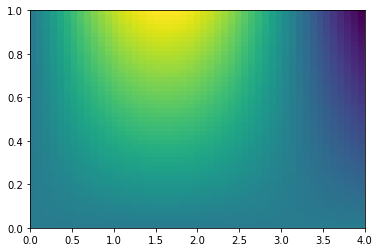

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,4)
y = np.linspace(0,1)

def f(x, y):
    return y * np.sin(x) 

X, Y = np.meshgrid(x,y)
Z = np.zeros((50,50))

for i in range(50):
   for j in range(50):
       Z[i,j] = f(X[i,j],Y[i,j])

plt.pcolor(X, Y, Z)
plt.show()


In [16]:
val = np.array([1.985462,1.2462352])
val.round(2)

array([1.99, 1.25])